# **POtato Disease App**

This notebook represents the model_build part of the app: 

- Data Loading
- Model building
- MLOps : Preprocessing, Pipeline, Data Augmentation etc.
- Model Save

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np

Download Dataset Images : https://www.kaggle.com/datasets/sumanrathaur/potato-disease



In [26]:
# Create dataset for training
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Plant_Disease_Train_Data",
    shuffle = True, 
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

class_names = dataset.class_names

Found 2152 files belonging to 3 classes.


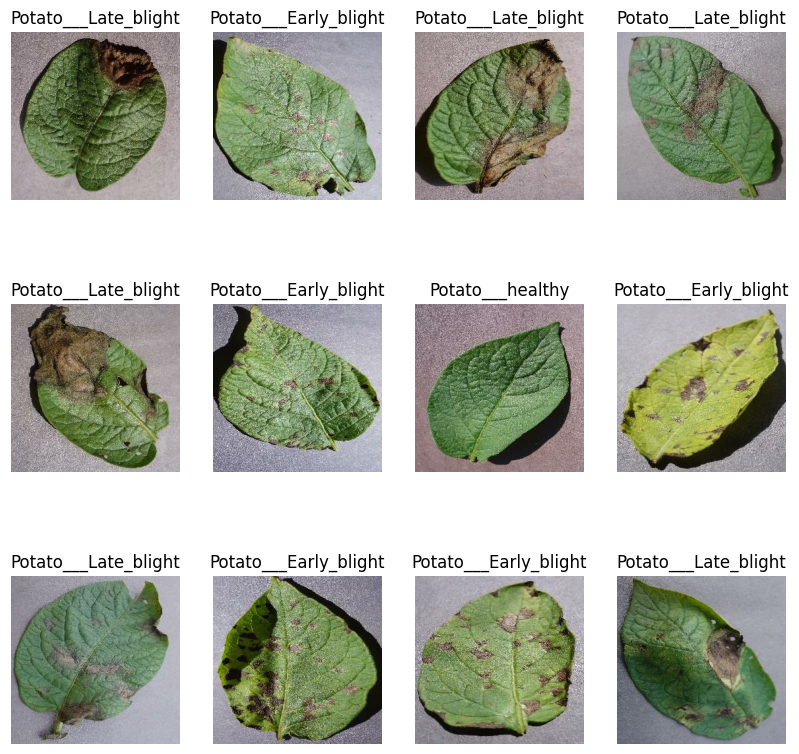

In [27]:
## Visualize data for understanding 
plt.figure(figsize = (10, 10))

for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

**Splitting structure**

- 80% ==> training

- 20% ==> 10% validation, 10% test

In [28]:
## Split data function

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


### **Pipeline Optimization : Cache, Shuffle, and Prefetch the Dataset**

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# **Building the CNN Model**

## **1) Preprocessing Data**

### **a) Creating a Layer for Resizing and Normalization**

- Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

- The resizing layer is used in case someone provides an image with different dimensions.

In [31]:
resize_and_rescale_layers = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### **b) Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data. So we create duplicated of the initial data implementing different transformations (RandomFlip, RandomRotation)

In [32]:
data_augmentation_layers = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

### **Model Architecture**

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale_layers,
    data_augmentation_layers,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(), # Flattening to get an array of neurons
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), # Softmax : Normalizing the propability of the classes 
])

model.build(input_shape=input_shape)

c:\Users\Altair\AppData\Local\Programs\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

### **Model Train**

In [36]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10


54/54 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.5180 - loss: 0.9210 - val_accuracy: 0.7135 - val_loss: 0.8499
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6030 - loss: 0.7990 - val_accuracy: 0.8177 - val_loss: 0.4745
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7821 - loss: 0.5264 - val_accuracy: 0.8854 - val_loss: 0.2842
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8673 - loss: 0.3216 - val_accuracy: 0.9167 - val_loss: 0.1933
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8789 - loss: 0.2870 - val_accuracy: 0.9375 - val_loss: 0.1776
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8880 - loss: 0.2707 - val_accuracy: 0.9479 - val_loss: 0.1653
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9235 - loss: 0.2225 - val_accuracy: 0.9375 - val_loss: 0.1501
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9349 - loss: 0.1890 - val_accuracy: 0.9271 - val_loss: 0.

In [37]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.9244 - loss: 0.1959


[0.2088162899017334, 0.9140625]

**The above evaluation depicts 100% accuracy on the training set. For the test set this value will differ**

**For visualization and better understanding, we plot the accuracy and loss curves. Also we print specific model data**

Model Parameters : {'verbose': 1, 'epochs': 10, 'steps': 54}
Model keys : dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Model Losses on each epochs : [0.8976665139198303, 0.7340065836906433, 0.501644492149353, 0.3195796310901642, 0.27792370319366455, 0.2655177712440491, 0.2176387757062912, 0.2228921800851822, 0.1874648779630661, 0.1715535819530487]


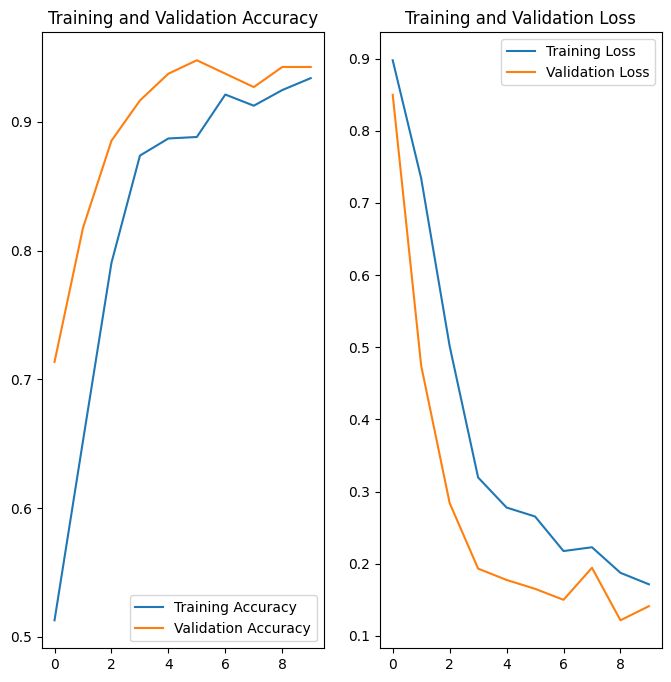

In [40]:
print(f'Model Parameters : {history.params}')
print(f'Model keys : {history.history.keys()}')

lossses = history.history['loss']
print(f'Model Losses on each epochs : {lossses}')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
predicted label: Potato___Early_blight


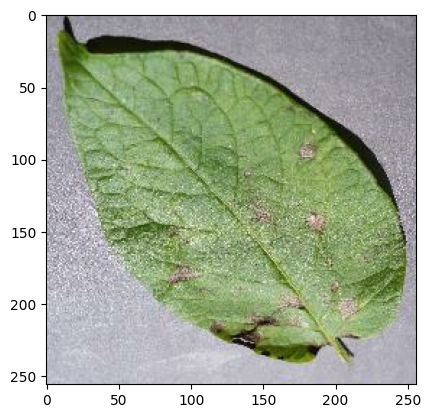

In [41]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    # The predicted value is a 3 element array. This array contains propabilities, and the highest of them is the predicted class. 

### **Inference function :**

In [42]:
# This function tells us what is the class and what is the confidence of this class
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
# Run inference function in couple of images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
# Save the CNN model 

import os
model_version = 1
# model.save(f"./models/{model_version}")
model.save(f"./models/CNN_potato_model_v{model_version}.keras")